# Performing a basic analysis - Normalised Burn Ratio

### Load packages
* 'sys' provdies access to helpful support functions in the 'dea_plotting' module.
* 'datacube' provides the ability to query and load data.
* 'matplotlib' provides the ability to format and manipulate plots.

In [1]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
from datacube.helpers import write_geotiff

sys.path.append("../Scripts")
from dea_plotting import display_map
from dea_plotting import rgb

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='basic_nbr')

### Step 1: Choose a study area

In [3]:
# Set the central latitude and longitude
central_lat = -35.396028
central_lon = 149.598931

# Set the buffer to load around the central coordinates
buffer = 0.025

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat)

### Step 2: Loading data

In [6]:
# Set the data source - s2a corresponds to Sentinel-2A
set_product = "s2a_ard_granule"

# Set the date range to load data over
set_time = ("2019-11-01", "2019-12-31")

# Set the measurements/bands to load
# For this analysis, we'll load the red, green, blue and near-infrared bands
set_measurements = [
    "nbar_red",
    "nbar_blue",
    "nbar_green",
    "nbar_nir_1",
    "nbar_swir_2"
]

# Set the coordinate reference system and output resolution
# This choice corresponds to Australian Albers, with resolution in metres
set_crs = "epsg:3577"
set_resolution = (-100, 100)

# Load the dataset
dataset = dc.load(
    product=set_product,
    x=study_area_lon,
    y=study_area_lat,
    time=set_time,
    measurements=set_measurements,
    output_crs=set_crs,
    resolution=set_resolution,
    resampling="average"
)

print(dataset)

<xarray.Dataset>
Dimensions:      (time: 4, x: 53, y: 62)
Coordinates:
  * time         (time) datetime64[ns] 2019-11-01T00:02:41.024000 ... 2019-12...
  * y            (y) float64 -3.973e+06 -3.973e+06 ... -3.979e+06 -3.979e+06
  * x            (x) float64 1.588e+06 1.588e+06 ... 1.593e+06 1.594e+06
    spatial_ref  int32 3577
Data variables:
    nbar_red     (time, y, x) int16 462 412 393 417 465 ... 512 515 537 530 551
    nbar_blue    (time, y, x) int16 354 335 329 336 352 ... 411 408 429 434 458
    nbar_green   (time, y, x) int16 422 385 381 404 426 ... 462 471 502 494 508
    nbar_nir_1   (time, y, x) int16 1803 1710 1763 1894 ... 1419 1542 1332 1348
    nbar_swir_2  (time, y, x) int16 1572 1332 1316 1434 ... 1555 1668 1792 1857
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref


### Step 3: Plotting the data

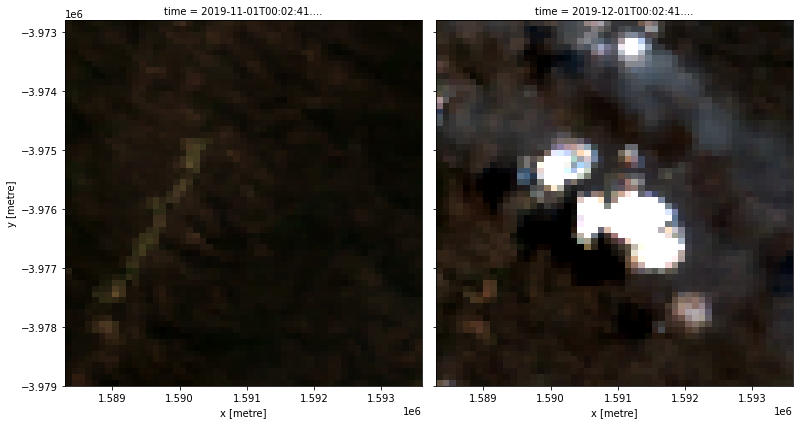

In [7]:
# Set the time step to view
time_step = 0

# Set the band combination to plot
bands = ["nbar_red", "nbar_green", "nbar_blue"]

# Generate the image by running the rgb function
rgb(dataset, bands=bands, index=[0,-1])



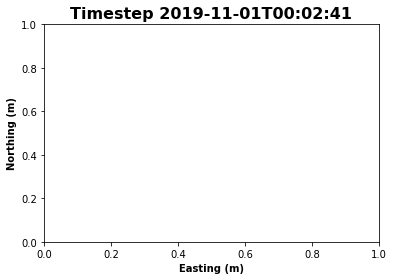

In [8]:
# Format the time stamp for use as the plot title
time_string = str(dataset.time.isel(time=time_step).values).split('.')[0]  

# Set the title and axis labels
ax = plt.gca()
ax.set_title(f"Timestep {time_string}", fontweight='bold', fontsize=16)
ax.set_xlabel('Easting (m)', fontweight='bold')
ax.set_ylabel('Northing (m)', fontweight='bold')

# Display the plot
plt.show()

### Step 4: Calculate normalised burn ratio

Check out some colour ramps on https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

The standard colormaps also all have reversed versions. They have the same names with '_r' tacked on to the end.

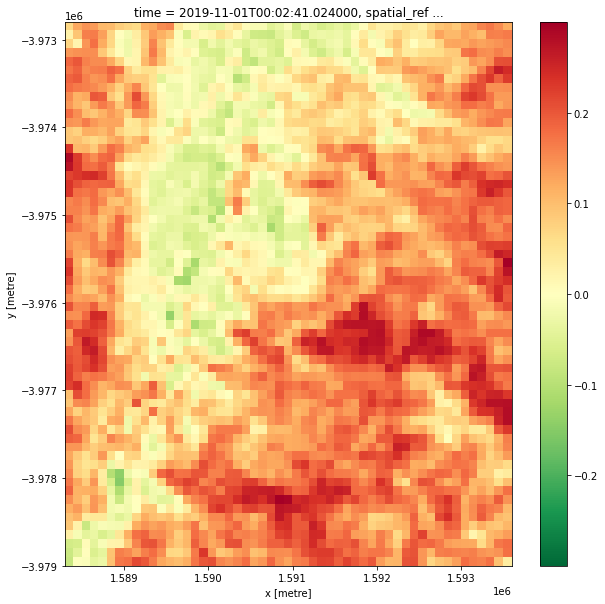

In [10]:
# Calculate the components that make up the NBR calculation
band_diff = dataset.nbar_nir_1 - dataset.nbar_swir_2
band_sum = dataset.nbar_nir_1 + dataset.nbar_swir_2

# Calculate NBR and store it as a measurement in the original dataset
nbr = band_diff / band_sum

# Set the NBR time step to view
nbr_time_step = 0

# This is the simple way to plot
# Note that high values are likely to be burnt.
plt.figure(figsize=(10, 10))
nbr.isel(time=nbr_time_step).plot(cmap="RdYlGn_r")
plt.show()

### Step 5: Exporting data

In [ ]:
# # You can change this, if you like.
# filename = "example.tiff"

# write_geotiff(dataset=dataset.isel(time=time_step), filename=filename)